<a href="https://colab.research.google.com/github/GeniGaus/NLP/blob/master/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!ls drive/NLP

test_qa.txt  train_qa.txt


In [0]:
import os
os.chdir('drive/NLP')

In [0]:
import pickle
import numpy as np

In [0]:
def get_data(filepath):
  data = []
  with open(filepath,"rb") as fp:
    data = pickle.load(fp)
  
  return data

In [0]:
train_data = get_data("train_qa.txt")
test_data = get_data("test_qa.txt")

In [11]:
print(f"Train data: {type(train_data)}, {len(train_data)}")
print(f"Test data: {type(test_data)}, {len(test_data)}")

Train data: <class 'list'>, 10000
Test data: <class 'list'>, 1000


### Setting up Vocabulary of all words
----------------------


In [0]:
vocab = set()

all_data = train_data + test_data

In [0]:
for story, query, ans in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(query))

In [0]:
vocab.add('no')
vocab.add('yes')

In [16]:
print(vocab)
print(len(vocab))

{'Sandra', 'John', 'picked', 'put', 'bedroom', 'office', 'Is', 'in', 'football', 'there', 'milk', 'apple', 'Daniel', 'grabbed', 'to', 'the', 'dropped', 'yes', 'hallway', 'travelled', 'got', 'garden', 'no', 'left', 'went', 'down', 'bathroom', '.', 'journeyed', 'Mary', 'back', 'up', 'moved', 'took', 'discarded', 'kitchen', '?'}
37


In [0]:
# Add an extra space to hold 0 for Keras pad_sequences
vocab_len = len(vocab) + 1

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [21]:
tokenizer.word_index

{'.': 28,
 '?': 37,
 'apple': 12,
 'back': 31,
 'bathroom': 27,
 'bedroom': 5,
 'daniel': 13,
 'discarded': 35,
 'down': 26,
 'dropped': 17,
 'football': 9,
 'garden': 22,
 'got': 21,
 'grabbed': 14,
 'hallway': 19,
 'in': 8,
 'is': 7,
 'john': 2,
 'journeyed': 29,
 'kitchen': 36,
 'left': 24,
 'mary': 30,
 'milk': 11,
 'moved': 33,
 'no': 23,
 'office': 6,
 'picked': 3,
 'put': 4,
 'sandra': 1,
 'the': 16,
 'there': 10,
 'to': 15,
 'took': 34,
 'travelled': 20,
 'up': 32,
 'went': 25,
 'yes': 18}

In [0]:
train_story_text = []
train_question_text = []
train_answers = []

for story,ques,ans in train_data:
  train_story_text.append(story)
  train_question_text.append(ques)

In [27]:
print(f"Story: {len(train_story_text)}")
print(f"Questions: {len(train_question_text)}")
#print(f"Story: {len(train_story_text)}")

Story: 10000
Questions: 10000


In [0]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [30]:
print(train_story_text[0])
print(train_story_seq[0])

['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.']
[30, 33, 15, 16, 27, 28, 1, 29, 15, 16, 5, 28]


In [0]:
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])

### Functionalize Vectorization
----------------------


In [0]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
  '''
  INPUT: 
    
  data: consisting of Stories,Queries,and Answers
  word_index: word index dictionary from tokenizer
  max_story_len: the length of the longest story (used for pad_sequences function)
  max_question_len: length of the longest question (used for pad_sequences function)


  OUTPUT:

  Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
  answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
  output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.

  Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
  '''

    
  # X = STORIES
  X = []
  # Xq = QUERY/QUESTION
  Xq = []
  # Y = CORRECT ANSWER
  Y = []


  for story, query, answer in data:
    
    # Grab the word index for every word in story
    x = [word_index[word.lower()] for word in story]
    # Grab the word index for every word in query
    xq = [word_index[word.lower()] for word in query]

    # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
    # Index 0 is reserved so we're going to use + 1
    y = np.zeros(len(word_index) + 1)

    # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
    #
    y[word_index[answer]] = 1

    # Append each set of story,query, and answer to their respective holding lists
    X.append(x)
    Xq.append(xq)
    Y.append(y)

  # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.

  # RETURN TUPLE FOR UNPACKING
  return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [0]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [0]:
vocab_size = len(vocab) + 1

## Creating the Model
------


In [0]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [0]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [37]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

In [0]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

#### Encode Sequences

In [0]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

Use dot product to compute the match between first input vector seq and the query

In [0]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

Add this match matrix with the second input vector sequence

In [0]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [0]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [44]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [0]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [0]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [0]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [49]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 8s 763us/step - loss: 0.9244 - acc: 0.4993 - val_loss: 0.6948 - val_acc: 0.5030
Epoch 2/120
10000/10000 [==============================] - 4s 449us/step - loss: 0.7053 - acc: 0.5004 - val_loss: 0.6950 - val_acc: 0.5030
Epoch 3/120
10000/10000 [==============================] - 5s 468us/step - loss: 0.6962 - acc: 0.5052 - val_loss: 0.6940 - val_acc: 0.5030
Epoch 4/120
10000/10000 [==============================] - 5s 479us/step - loss: 0.6953 - acc: 0.4959 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 5/120
10000/10000 [==============================] - 4s 448us/step - loss: 0.6945 - acc: 0.5096 - val_loss: 0.6949 - val_acc: 0.4970
Epoch 6/120
10000/10000 [==============================] - 5s 499us/step - loss: 0.6947 - acc: 0.4963 - val_loss: 0.6935 - val_acc

### Saving the model
----


In [0]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

### Evaluating the model
----


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


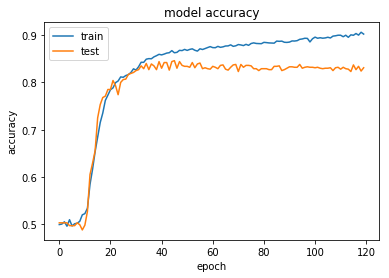

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [53]:
story =' '.join(word for word in test_data[10][0])
print(story)

query = ' '.join(word for word in test_data[10][1])
print(query)

print("True Test Answer from Data is:",test_data[10][2])

John moved to the hallway . Sandra went to the bedroom .
Is John in the hallway ?
True Test Answer from Data is: yes


In [56]:
#Generate prediction from model
val_max = np.argmax(pred_results[10])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[10][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.68367696
